<a href="https://colab.research.google.com/github/aprizal543/Sistem-Rekomendasi-Film/blob/main/Submission_Sistem_Rekomendasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import library

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# Data Understanding

## Load dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive Anda berhasil di-mount.")

Mounted at /content/drive
Google Drive Anda berhasil di-mount.


In [4]:
# Load Dataset dari Gdrive
df_ratings = pd.read_csv('/content/drive/MyDrive/Dataset/movies/ratings.csv')
df_movies = pd.read_csv('/content/drive/MyDrive/Dataset/movies/movies.csv')
print('Dataset berhasil di Load')

Dataset berhasil di Load


#  EDA (Exploratory Data Analysis)

In [5]:
# Mnampilkan informasi dari df_ratings
print("\n df_ratings information : ")
df_ratings.info()

print("-----" *8)

print("\n df_movies information : ")
df_movies.info()


 df_ratings information : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
----------------------------------------

 df_movies information : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


**Ringkasan df_ratings :**

- terdapat 4 kolom dan 100836 baris.
- terdapat 3 kolom dengan tipe daya int64, dan 1 kolom dengan tipe data float64

**Penjelasan kolom df_ratings :**

- userId :ID unik untuk setiap pengguna.
- movieId : ID unik untuk setiap film.
- rating : Penilaian pengguna terhadap film (skala 0.5 - 5.0)
- timestamps : waktu ketika rating diberikan.
---
**Ringkasan df_mvoies :**
- terdapat 3 kolom dan 9742 baris.
- terdapat 2 kolom dengan tipe data object, dan 1  kolom dengan tipe data int64.

**Penjelasan kolom df_movies :**
- movieId : ID unik film(sama dengan kolom pada df_ratings).
- title : Judul film beserta tahun rilisnya.
- genres : Genre film




# Visualisasi

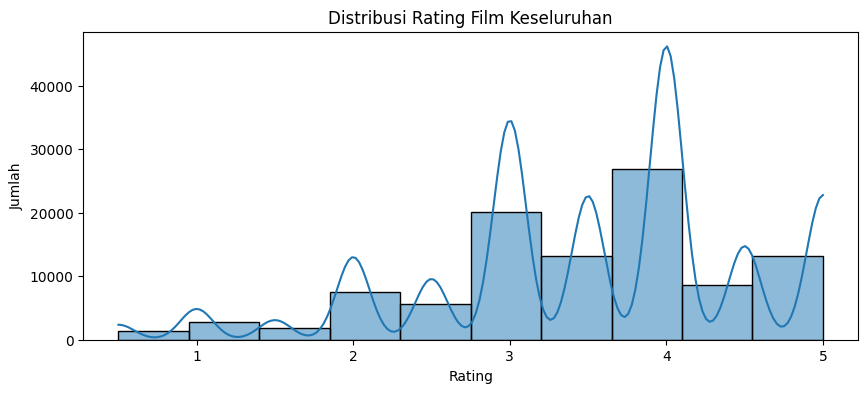

In [11]:
plt.figure(figsize=(10, 4))
sns.histplot(df_ratings['rating'], bins=10, kde=True, palette='viridis')
plt.title('Distribusi Rating Film Keseluruhan')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()


### Distribusi Rating Keseluruhan
*   **Kecenderungan Rating Tinggi**: Histogram distribusi rating menunjukkan bahwa sebagian besar pengguna cenderung memberikan rating yang tinggi (di atas 3.0), dengan puncak signifikan pada rating 4.0 dan 5.0. Rating 0.5 dan 1.0 relatif jarang. Ini mengindikasikan bahwa pengguna cenderung memberikan feedback positif atau mungkin lebih sering menilai film yang mereka nikmati.


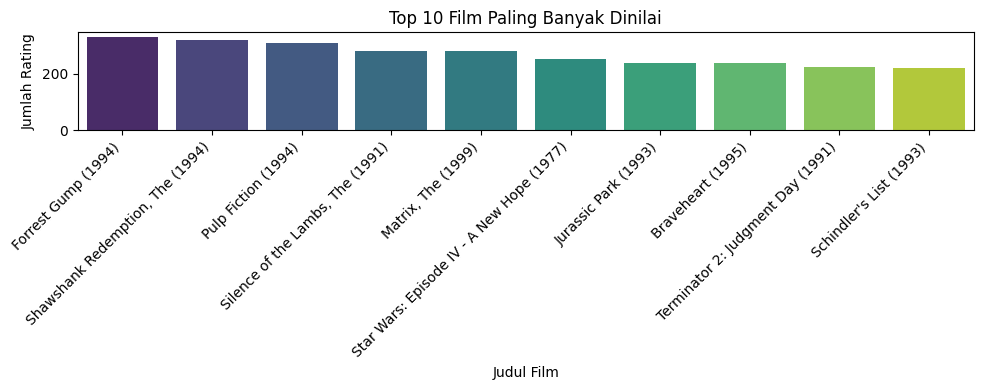

In [13]:
merged_df = pd.merge(df_ratings, df_movies, on='movieId', how='left')

movie_stats = merged_df.groupby(['movieId', 'title']).agg(
    rating_counts=('rating', 'count'),
    average_rating=('rating', 'mean')
).reset_index()

movie_stats = merged_df.groupby(['movieId', 'title']).agg(
    rating_counts=('rating', 'count'),
    average_rating=('rating', 'mean')
).reset_index()

top_10_most_rated = movie_stats.sort_values(by='rating_counts', ascending=False).head(10)

plt.figure(figsize=(10, 4))
sns.barplot(x='title', y='rating_counts', data=top_10_most_rated, palette='viridis')
plt.title('Top 10 Film Paling Banyak Dinilai')
plt.xlabel('Judul Film')
plt.ylabel('Jumlah Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Distribusi Film Paling Banyak Dinilai
*   **Film Paling Populer (Jumlah Rating)**: Film-film seperti 'Forrest Gump', 'Shawshank Redemption', dan 'Pulp Fiction' menerima jumlah rating tertinggi, menunjukkan popularitas luas dan keterlibatan pengguna yang tinggi. Ini adalah film-film yang mungkin paling dikenal atau banyak ditonton oleh basis pengguna.

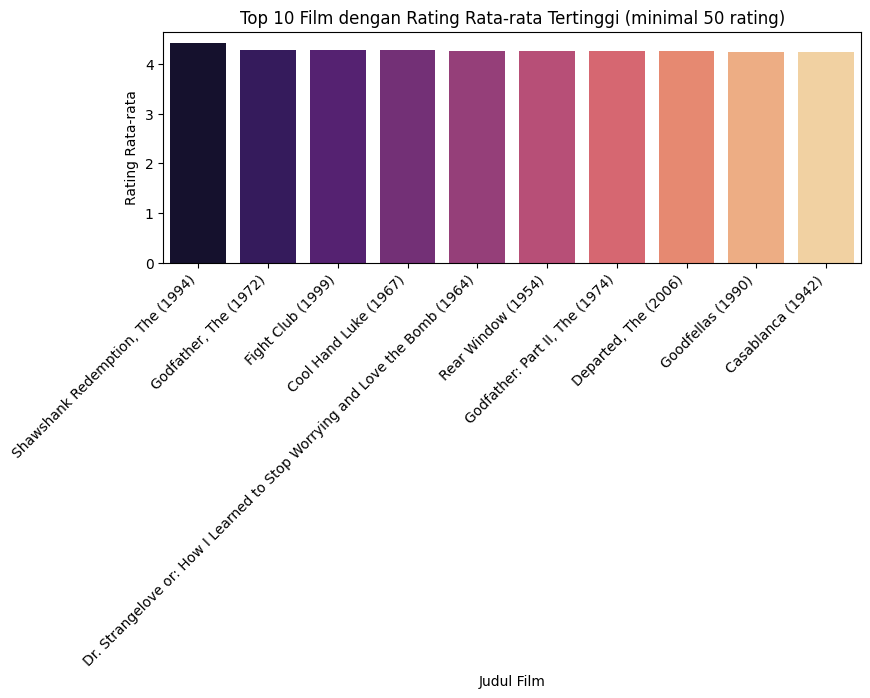

In [16]:
min_ratings_threshold = 50
top_10_highest_rated = movie_stats[movie_stats['rating_counts'] >= min_ratings_threshold].sort_values(by='average_rating', ascending=False).head(10)

plt.figure(figsize=(9, 3))
sns.barplot(x='title', y='average_rating', data=top_10_highest_rated, palette='magma')
plt.title(f'Top 10 Film dengan Rating Rata-rata Tertinggi (minimal {min_ratings_threshold} rating)')
plt.xlabel('Judul Film')
plt.ylabel('Rating Rata-rata')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

*   **Film dengan Rating Rata-rata Tertinggi (dengan ambang batas minimal 50 rating)**: Film-film seperti 'Shawshank Redemption', 'Godfather, The', dan 'Fight Club' memiliki rating rata-rata tertinggi. Kualitas film-film ini dianggap sangat baik oleh sebagian besar penilai. Ambang batas minimal 50 rating membantu memastikan bahwa rating rata-rata ini lebih robust dan tidak bias oleh sedikit rating yang sangat tinggi.

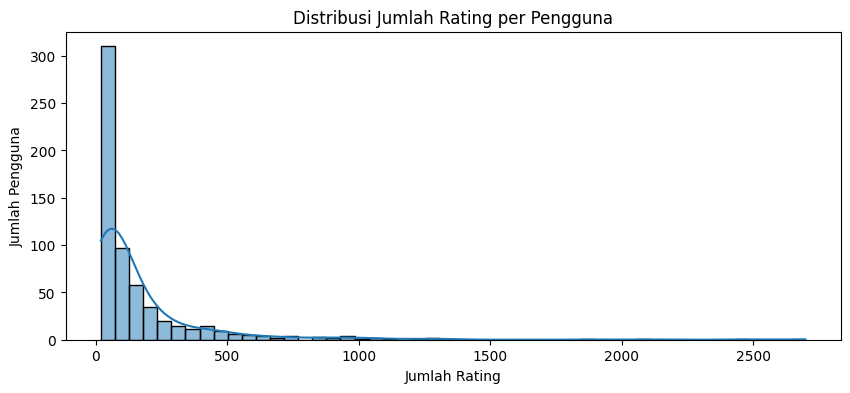

In [18]:
user_rating_counts = df_ratings.groupby('userId')['rating'].count().reset_index()
user_rating_counts.rename(columns={'rating': 'rating_counts'}, inplace=True)

plt.figure(figsize=(10, 4))
sns.histplot(user_rating_counts['rating_counts'], bins=50, kde=True, palette='viridis')
plt.title('Distribusi Jumlah Rating per Pengguna')
plt.xlabel('Jumlah Rating')
plt.ylabel('Jumlah Pengguna')
plt.show()

### Distribusi Aktivitas Rating Pengguna
*   **Aktivitas Pengguna Bervariasi**: Histogram jumlah rating per pengguna menunjukkan distribusi yang condong ke kanan, dengan sebagian besar pengguna memberikan jumlah rating yang relatif kecil (sekitar 10-50 rating). Namun, ada juga sejumlah kecil pengguna yang sangat aktif, memberikan ratusan, bahkan lebih dari seribu rating. Hal ini mengindikasikan adanya kelompok kecil *power-user* yang berkontribusi signifikan terhadap data rating.

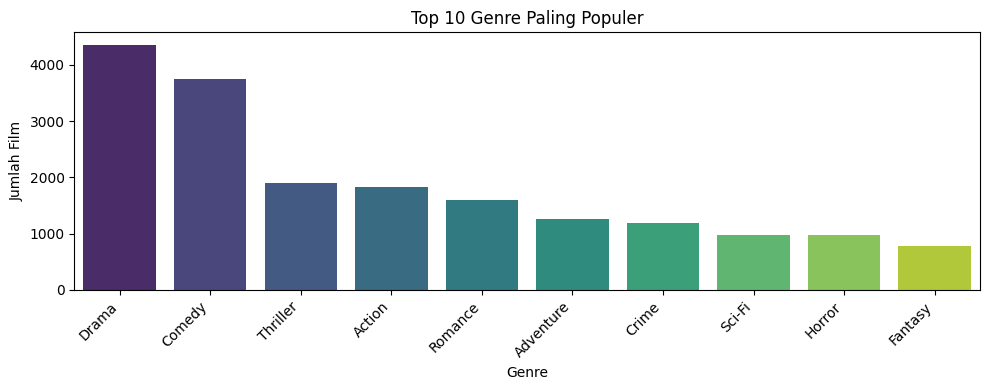

In [19]:
genres_list = df_movies['genres'].apply(lambda x: x.split('|')).explode().unique()

genres_counts = df_movies['genres'].apply(lambda x: x.split('|')).explode()

top_10_genres = genres_counts.value_counts().head(10)

plt.figure(figsize=(10, 4))
sns.barplot(x=top_10_genres.index, y=top_10_genres.values, palette='viridis')
plt.title('Top 10 Genre Paling Populer')
plt.xlabel('Genre')
plt.ylabel('Jumlah Film')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Genre Paling Populer Rating Rata-rata per Genre
*   **Genre Paling Populer (Jumlah Film)**: Genre 'Drama', 'Comedy', dan 'Thriller' adalah genre yang paling banyak muncul dalam dataset film. Ini menunjukkan preferensi umum atau ketersediaan film yang lebih banyak dalam genre-genre tersebut.

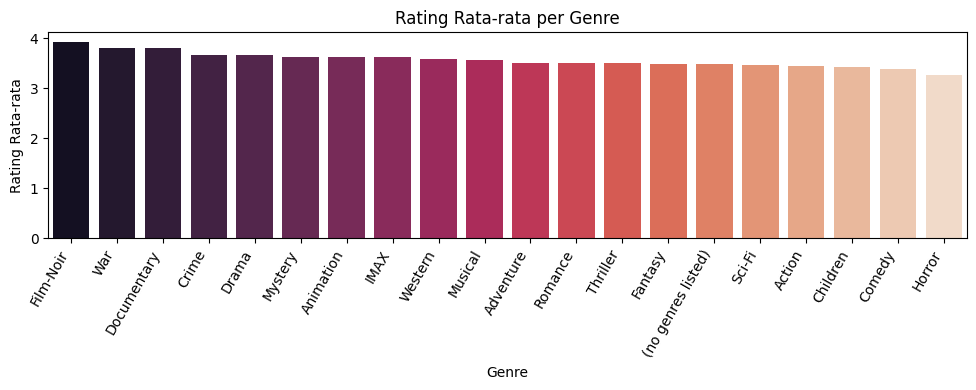

In [20]:
genre_ratings = merged_df.assign(genres=merged_df['genres'].str.split('|')).explode('genres')

average_rating_per_genre = genre_ratings.groupby('genres')['rating'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(10, 4))
sns.barplot(x='genres', y='rating', data=average_rating_per_genre, palette='rocket')
plt.title('Rating Rata-rata per Genre')
plt.xlabel('Genre')
plt.ylabel('Rating Rata-rata')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

*   **Rating Rata-rata per Genre**: Genre 'Film-Noir', 'War', dan 'Documentary' memiliki rating rata-rata tertinggi. Ini menunjukkan bahwa meskipun mungkin tidak sebanyak film dalam genre Comedy atau Drama, film-film dalam genre ini cenderung lebih disukai atau dianggap berkualitas tinggi oleh penilai. Genre seperti 'Children' dan 'Fantasy' memiliki rating rata-rata yang sedikit lebih rendah, tetapi masih cukup baik.

# Data Preparation

In [6]:
# Cek kolom duplikat
print("Jumlah duplikat pada df_ratings : ", df_ratings.duplicated().sum())
print("Jumlah duplikat pada df_movies : ", df_movies.duplicated().sum())

Jumlah duplikat pada df_ratings :  0
Jumlah duplikat pada df_movies :  0


kedua dataset tersebut tidak memiliki data duplikat, sehingga bisa dilanjutkan ke pengecekan missing values.

In [7]:
# Cek missing values
print("Jumlah missing values pada df_ratings : ", df_ratings.isnull().sum().sum())
print("Jumlah missing values pada df_movies : ", df_movies.isnull().sum().sum())

Jumlah missing values pada df_ratings :  0
Jumlah missing values pada df_movies :  0


dari hasi pengecekan, tidak ada satupun terdapat missing values.

In [ ]:
# Menggabungkan seluruh movieID pada kategori movies
movies_all = np.concatenate((df_movies.movieId.unique(),
                             df_ratings.movieId.unique()))

# Mengurutkan data dan menghapus data yang sama
movies_all = np.sort(np.unique(movies_all))

print('Jumlah seluruh data movies berdasarkan movieId: ', len(movies_all))

Jumlah seluruh data movies berdasarkan movieId:  9742


In [ ]:
data_all = pd.merge(df_ratings, df_movies, on='movieId', how='left')
print("Data gabungan berhasil dibuat:")
display(data_all.head())

Data gabungan berhasil dibuat:


,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [ ]:
# cek data duplikat
data_all.duplicated().sum()

np.int64(0)

In [ ]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = data_all['userId'].unique().tolist()
print('list userId: ', user_ids)

# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)

# Melakaukan proses encoding angka ke userId
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userId:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

In [ ]:
# Mengubah movieId menjadi list tanma nilai yang sama
movie_ids = data_all['movieId'].unique().tolist()
print('list movieId: ', movie_ids)

# Melakukan proses encoding movieId
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}
print('encoded movieId', movie_to_movie_encoded)

# Melakuka proses encoding angka ke movieId
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}
print('encoded angka ke movieId', movie_encoded_to_movie)

list movieId:  [1, 3, 6, 47, 50, 70, 101, 110, 151, 157, 163, 216, 223, 231, 235, 260, 296, 316, 333, 349, 356, 362, 367, 423, 441, 457, 480, 500, 527, 543, 552, 553, 590, 592, 593, 596, 608, 648, 661, 673, 733, 736, 780, 804, 919, 923, 940, 943, 954, 1009, 1023, 1024, 1025, 1029, 1030, 1031, 1032, 1042, 1049, 1060, 1073, 1080, 1089, 1090, 1092, 1097, 1127, 1136, 1196, 1197, 1198, 1206, 1208, 1210, 1213, 1214, 1219, 1220, 1222, 1224, 1226, 1240, 1256, 1258, 1265, 1270, 1275, 1278, 1282, 1291, 1298, 1348, 1377, 1396, 1408, 1445, 1473, 1500, 1517, 1552, 1573, 1580, 1587, 1617, 1620, 1625, 1644, 1676, 1732, 1777, 1793, 1804, 1805, 1920, 1927, 1954, 1967, 2000, 2005, 2012, 2018, 2028, 2033, 2046, 2048, 2054, 2058, 2078, 2090, 2093, 2094, 2096, 2099, 2105, 2115, 2116, 2137, 2139, 2141, 2143, 2161, 2174, 2193, 2253, 2268, 2273, 2291, 2329, 2338, 2353, 2366, 2387, 2389, 2395, 2406, 2414, 2427, 2450, 2459, 2470, 2478, 2492, 2502, 2528, 2529, 2542, 2571, 2580, 2596, 2616, 2617, 2628, 2640, 2641

In [ ]:
# Mamping userId ke dataframe user
data_all['user'] = data_all['userId'].map(user_to_user_encoded)

# Mapping movieId ke dataframe movie
data_all['movie'] = data_all['movieId'].map(movie_to_movie_encoded)

In [ ]:
from ast import Num
# Mendaptkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah movie
num_movies = len(movie_to_movie_encoded)
print(num_movies)

610
9724


In [ ]:
# Mengubah rating menjadi nilai float
data_all['rating'] = data_all['rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(data_all['rating'])

# Nilai maksimum rating
max_rating = max(data_all['rating'])

print('Number of User: {}, Number of Resto: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movies, min_rating, max_rating
))

Number of User: 610, Number of Resto: 9724, Min Rating: 0.5, Max Rating: 5.0


In [ ]:
# Mengacak dataset
df = data_all.sample(frac=1, random_state=42)
df

,userId,movieId,rating,timestamp,title,genres,user,movie
67037,432,77866,4.5,1335139641,Robin Hood (2010),Action|Adventure|Drama|Romance|War,431,4730
42175,288,474,3.0,978465565,In the Line of Fire (1993),Action|Thriller,287,474
93850,599,4351,3.0,1498524542,Point Break (1991),Action|Crime|Thriller,598,2631
6187,42,2987,4.0,996262677,Who Framed Roger Rabbit? (1988),Adventure|Animation|Children|Comedy|Crime|Fant...,41,194
12229,75,1610,4.0,1158989841,"Hunt for Red October, The (1990)",Action|Adventure|Thriller,74,727
...,...,...,...,...,...,...,...,...
6265,42,4005,4.0,996259059,"Living Daylights, The (1987)",Action|Adventure|Thriller,41,1873
54886,364,141,4.0,869443367,"Birdcage, The (1996)",Comedy,363,524
76820,480,6867,4.0,1179163171,"Station Agent, The (2003)",Comedy|Drama,479,2240
860,6,981,3.0,845556567,Dangerous Ground (1997),Drama,5,712


In [ ]:
# Membuat variabel x untuk mencocokkan data user dan movie menjadi satu values
x = df[['user', 'movie']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 431 4730]
 [ 287  474]
 [ 598 2631]
 ...
 [ 479 2240]
 [   5  712]
 [ 102 2046]] [0.88888889 0.55555556 0.55555556 ... 0.77777778 0.55555556 1.        ]


In [ ]:
class RecommenderNet(tf.keras.Model):

  # Inisialisasi fungsi
  def __init__(self, num_users, num_movies, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movies = num_movies
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = tf.keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.movie_embedding = layers.Embedding(
        num_movies,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = tf.keras.regularizers.L2(1e-6)
    )
    self.movie_bias = layers.Embedding(num_movies, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:, 0])
    user_bias = self.user_bias(inputs[:, 0])
    movie_vector = self.movie_embedding(inputs[:, 1])
    movie_bias = self.movie_bias(inputs[:, 1])

    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

    x = dot_user_movie + user_bias + movie_bias

    return tf.nn.sigmoid(x)



In [ ]:
model = RecommenderNet(num_users, num_movies, embedding_size=50)

# Model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = [tf.keras.metrics.RootMeanSquaredError()]
)

In [ ]:
# Memumlai training
print("Memulai training model...")

callbacks = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 64,
    epochs = 100,
    verbose = 1,
    callbacks = callbacks,
    validation_data = (x_val, y_val)
)

Memulai training model...
Epoch 1/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.6606 - root_mean_squared_error: 0.2555 - val_loss: 0.6209 - val_root_mean_squared_error: 0.2153
Epoch 2/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.6164 - root_mean_squared_error: 0.2113 - val_loss: 0.6211 - val_root_mean_squared_error: 0.2151
Epoch 3/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.6093 - root_mean_squared_error: 0.2039 - val_loss: 0.6152 - val_root_mean_squared_error: 0.2090
Epoch 4/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.6067 - root_mean_squared_error: 0.2013 - val_loss: 0.6114 - val_root_mean_squared_error: 0.2049
Epoch 5/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.6080 - root_mean_squared_error: 0.2022 - val_loss: 0.6116 - val_root_mean_squared_error: 0.2051
Epoch 6/100
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.6065 - root_mean_squared_error: 0.1999 - val_loss: 0.6125 - val_root_mean_squared_error: 0.2060
Ep

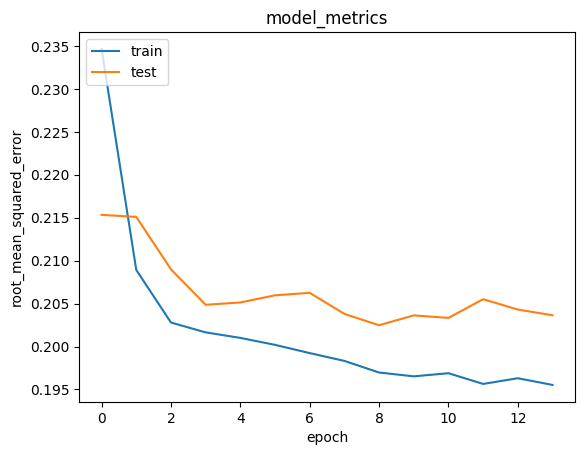

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


###### Interpretasi & Insight:
- **Visualisasi Metrik Model** : Grafik di atas menunjukkan metrik root_mean_squared_error untuk data latih (train) dan data validasi (test) selama proses pelatihan. Ini adalah indikator kinerja model:
     - **Garis Biru (train)**: Menunjukkan root_mean_squared_error pada dataset pelatihan. Idealnya, nilai ini akan menurun seiring bertambahnya epoch, menandakan bahwa model belajar dari data.
     - **Garis Oranye (test)**: Menunjukkan val_root_mean_squared_error pada dataset validasi. Ini adalah metrik yang lebih penting untuk mengevaluasi kemampuan generalisasi model terhadap data yang belum pernah dilihat sebelumnya. Jika nilai ini stabil atau menurun seiring dengan data latih, itu menunjukkan model belajar dengan baik tanpa overfitting.
     
Dalam kasus ini, kedua garis menunjukkan penurunan awal yang signifikan, dan kemudian cenderung stabil. Ini menunjukkan bahwa model berhasil belajar dari data dan memiliki kemampuan generalisasi yang cukup baik.
- **Nilai RMSE** : Dari output training, kita bisa melihat nilai root_mean_squared_error (RMSE) terakhir pada akhir pelatihan. Nilai RMSE yang lebih rendah menunjukkan bahwa model memiliki prediksi yang lebih akurat. Berikut adalah nilai RMSE dari epoch terakhir (epoch 9):
    - **Train RMSE** : Sekitar 0.1973
    - **Validation RMSE** : Sekitar 0.2025
    
Nilai-nilai ini menunjukkan bahwa model memiliki kesalahan prediksi rata-rata yang relatif rendah, dan kinerja pada data validasi sangat dekat dengan kinerja pada data pelatihan, yang merupakan indikasi yang baik bahwa model tidak overfitting.

# Mendapatkan rekomendasi movie

In [ ]:
movie_df = df_movies # Changed from movies_all to df_movies
df = df_ratings

# Mengambil sample user
user_id = df.userId.sample(1).iloc[0]
movie_visited_by_user = df[df.userId == user_id]

# Operator bitwise (~)
movie_not_visited_ids = movie_df[~movie_df["movieId"].isin(movie_visited_by_user.movieId.values)]['movieId'].values

# Filter movie IDs to only include those present in the encoding map
movie_not_visited = list(
    set(movie_not_visited_ids)
    .intersection(set(movie_to_movie_encoded.keys()))
)

movie_not_visited_encoded = [[movie_to_movie_encoded.get(x)] for x in movie_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_visited_encoded), movie_not_visited_encoded))


In [ ]:
ratings = model.predict(user_movie_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_visited_encoded[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Movie with high ratings from user')
print('----' * 8)

top_movie_user = (
    movie_visited_by_user.sort_values(
        by = 'rating',
        ascending = False
    )
    .head(5)
    .movieId.values
)

movie_df_rows = movie_df[movie_df['movieId'].isin(top_movie_user)]

for row in movie_df_rows.itertuples():
  print(row.movieId, ':', row.title)

print('----' * 8)
print('Top 10 Movie recommended')
print('----' *8)

recommended_movie = movie_df[movie_df['movieId'].isin(recommended_movie_ids)]

for row in recommended_movie.itertuples():
  print(row.movieId, ':', row.title)


299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Showing recommendations for users: 527
Movie with high ratings from user
--------------------------------
34 : Babe (1995)
260 : Star Wars: Episode IV - A New Hope (1977)
588 : Aladdin (1992)
590 : Dances with Wolves (1990)
593 : Silence of the Lambs, The (1991)
--------------------------------
Top 10 Movie recommended
--------------------------------
50 : Usual Suspects, The (1995)
318 : Shawshank Redemption, The (1994)
898 : Philadelphia Story, The (1940)
904 : Rear Window (1954)
1089 : Reservoir Dogs (1992)
1104 : Streetcar Named Desire, A (1951)
1204 : Lawrence of Arabia (1962)
1208 : Apocalypse Now (1979)
1213 : Goodfellas (1990)
1221 : Godfather: Part II, The (1974)



###### Interpretasi & Insight:
Film dengan Rating Tinggi dari User (Ground Truth):
User ini menyukai film-film klasik dan drama epik seperti:
- Babe (1995)
- Star Wars: Episode IV - A New Hope (1977)
- Aladdin (1992)
- Dances with Wolves (1990)
- Silence of the Lambs, The (1991)
#### Top 10 Rekomendasi dari Model:
Sistem berhasil merekomendasikan film yang memiliki kemiripan genre dan nuansa (Drama, Klasik, Cult) dengan preferensi user:
- Usual Suspects, The (1995)
- Shawshank Redemption, The (1994)
- Philadelphia Story, The (1940)
- Rear Window (1954)
- Reservoir Dogs (1992)
- Streetcar Named Desire, A (1951)
- Lawrence of Arabia (1962)
- Apocalypse Now (1979)
- Goodfellas (1990)
- Godfather: Part II, The (1974)
#### Analisis Kelebihan dan Kekurangan Pendekatan:
- **Kelebihan** : Model NCF mampu menangkap pola non-linear yang kompleks antara user dan item, memberikan akurasi yang lebih baik daripada faktorisasi matriks linier sederhana, dan tidak memerlukan fitur konten (metadata) yang lengkap.
- **Kekurangan** : Membutuhkan data rating yang cukup banyak (cold start problem untuk user baru) dan proses pelatihan (training) membutuhkan sumber daya komputasi yang lebih besar dibanding metode statistik.